# NYC Real Estate Price Prediction

## Objective

We will predict the real estate price to help the people buy and sell at a reasonable price.



## Business problems we will solve:

Lack of appropriate price information of real estate in NYC for individual seller and
buyer.

What type of building a real estate developer should build for the most add-value.


**The Use Scenario:**

When one wants to sell the real estate, they can use the model we create and add some variables (location, year, area, etc) to get the appropriate prediction price.

**Data mining and modeling**

Price is a target variable, and we will use supervised machine learning with cross-validation to find out influential variables.


**Source of data**
NYC government official data.

https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page


# Data Understanding

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline


In [77]:
def load_data():
    df_mh=pd.read_excel("rollingsales_manhattan.xls",skiprows=4)
    df_mh["AREA"]="MH"
    df_bx=pd.read_excel("rollingsales_bronx.xls",skiprows=4)
    df_bx["AREA"]="BX"
    df=pd.concat([df_mh,df_bx])
    df.columns = df.columns.str.replace(' ', '_')
    df=df.drop(columns=['EASE-MENT'])# all the values in this column is nan.
    df['not_apartment']=df['APARTMENT_NUMBER'].isna()# ture: it is not an apartment. false: it is an apartment.
    df=df.drop(columns=['APARTMENT_NUMBER','ADDRESS','BUILDING_CLASS_AT_PRESENT'])
    
    df=df.dropna()
    return df

Here is how our data looks like:

In [78]:
df=load_data()
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,AREA,not_apartment
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,10009.0,1.0,0.0,1.0,987.0,2183.0,1860.0,1,A4,4844809,2018-05-22,MH,True
1,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,10009.0,1.0,0.0,1.0,987.0,2183.0,1860.0,1,A4,0,2018-05-23,MH,True
2,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,400,19,10009.0,1.0,0.0,1.0,1883.0,5200.0,1900.0,1,A4,6100000,2018-12-03,MH,True
3,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,390,35,10009.0,2.0,0.0,2.0,1218.0,4764.0,1899.0,1,B1,0,2018-04-25,MH,True
4,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,404,1,10009.0,2.0,0.0,2.0,1510.0,4520.0,1900.0,1,B9,0,2018-11-29,MH,True


Our target variable is SALE_PRICE.
So, let's take a look of the distribution.

In [79]:
df["SALE_PRICE"].describe()

count    2.443900e+04
mean     2.406437e+06
std      2.344970e+07
min      0.000000e+00
25%      1.000000e+01
50%      5.800000e+05
75%      1.340045e+06
max      2.397502e+09
Name: SALE_PRICE, dtype: float64

In [80]:
df["SALE_PRICE"] = df["SALE_PRICE"].replace(0, np.NaN)
df["SALE_PRICE"].describe()

count    1.850900e+04
mean     3.177423e+06
std      2.690026e+07
min      1.000000e+00
25%      4.750000e+05
50%      7.980000e+05
75%      1.790000e+06
max      2.397502e+09
Name: SALE_PRICE, dtype: float64

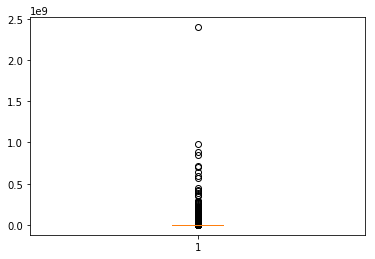

In [81]:
fig, ax = plt.subplots()
ax.boxplot(df[df["SALE_PRICE"]>0]["SALE_PRICE"]);

We find the range of the 'SALE_PRICE' varies a lot.
To wipe out unregular observation, We limit the price range from USD 100,000 to 100,000,000. 
which means, we exculde following percentage of data.

In [82]:
sum((df["SALE_PRICE"]<100000) | (df["SALE_PRICE"]>100000000))/len(df["SALE_PRICE"])

0.030197634927779368

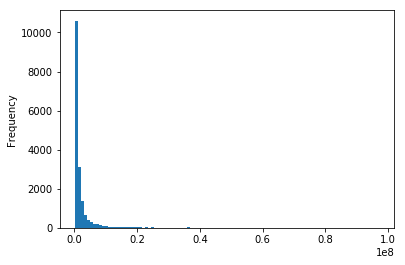

In [83]:
df[(df["SALE_PRICE"]>100000) & (df["SALE_PRICE"]<100000000)
  ]["SALE_PRICE"].plot.hist(bins=100);

Still, the range varies a lot. So we will take a log10.

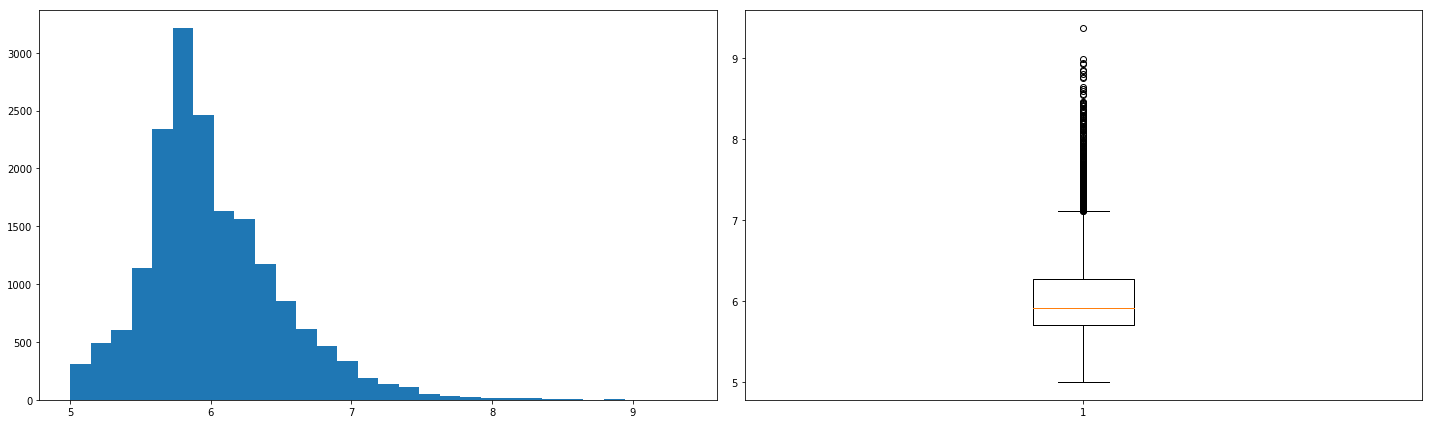

In [84]:
df["SALE_PRICE"] = df["SALE_PRICE"].replace(0, np.NaN)
df["Logged_SALE_PRICE"] = df["SALE_PRICE"].apply(np.log10)

rows = 1
cols = 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(10*cols, 6*rows))
axs = axs.flatten()
axs[0].hist(df[(df["Logged_SALE_PRICE"]>5)]["Logged_SALE_PRICE"], bins=30);
axs[1].boxplot(df[(df["Logged_SALE_PRICE"]>5)]["Logged_SALE_PRICE"]);
plt.tight_layout()   


So, it seems better than before. So, we will use our target value as Logged_SALE_PRICE.

## Another transformation we will need 

We have 'YEAR_BUILT' data which is a data when the building built.

However, the data itself has no mean as we need the "AGE" of the building.

So, we will create new variable called "AGE".

In [85]:
df["YEAR_BUILT"] = df["YEAR_BUILT"].replace(0, np.NaN)
df["SALE_DATE"] = df["SALE_DATE"].replace(0, np.NaN)
df["AGE"] = df["SALE_DATE"].dt.year - df["YEAR_BUILT"]
df["AGE"].head()

0    158.0
1    158.0
2    118.0
3    119.0
4    118.0
Name: AGE, dtype: float64

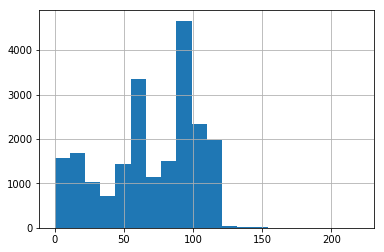

In [86]:
df["AGE"].hist(bins=20)

Also, the MONTH might be affect the value of the real estate if the other conditions hold:

So, we will create new variable called "SALE MONTH".

In [87]:
df["SALE_MONTH"] = df["SALE_DATE"].dt.month.astype(int)

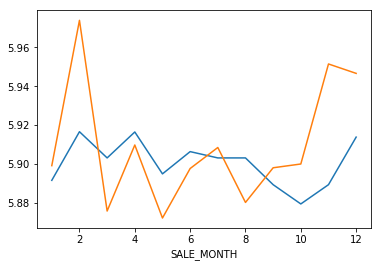

In [88]:
df.groupby("SALE_MONTH")["Logged_SALE_PRICE"].median().plot()
df.groupby("SALE_MONTH")["Logged_SALE_PRICE"].mean().plot()

## Data Plot with Logged_SALE_PRICE

### Categorical Variables and what they look like:

We select some variables 


In [ ]:
forboxplot = ['NEIGHBORHOOD','BUILDING_CLASS_CATEGORY','TAX_CLASS_AT_PRESENT', 'ZIP_CODE',"SALE_MONTH", 
              'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE','AREA','not_apartment',]

rows = len(forboxplot)
cols = 2 
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 5*rows))

j=0

for i in forboxplot:
    df.boxplot("Logged_SALE_PRICE", i, grid=False, sym='k.', ax=axes[j, 0])
    df.boxplot("SALE_PRICE", i, grid=False, sym='k.', ax=axes[j, 1])
    j += 1


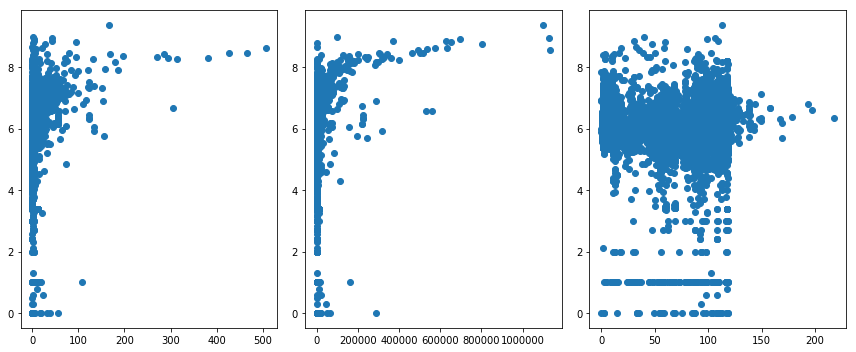

In [57]:
rows = 1
cols = 3

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(4*cols, 5*rows))
axs = axs.flatten()
j=0
features_selected = features_selected=['TOTAL_UNITS', 'GROSS_SQUARE_FEET','AGE']
for i in features_selected:
    axs[j].scatter(x=i, y="Logged_SALE_PRICE",data=df)
    j = j+1
plt.tight_layout()   
